In [15]:
import sklearn
from sklearn import datasets
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
import pandas
import seaborn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
# %matplotlib inline

#### Mask the dataset creation for educational purposes (viewer: do not open)

In [16]:
data, labels = datasets.make_classification(n_samples=100, n_features=5, n_classes=2, n_informative=3, n_redundant=0, n_repeated=0, random_state=7)

# Generates the same decision tree as in Decision-Trees-1.ipynb

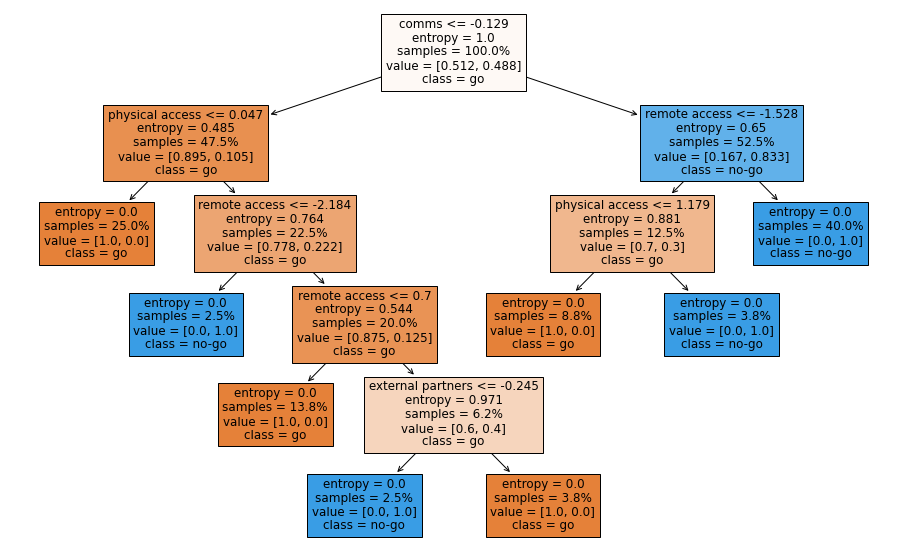

Average Accuracy: 80.0%


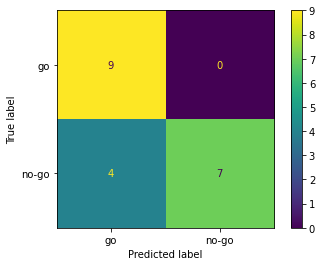

In [17]:
df_data = pandas.DataFrame(data, columns=['comms', 'remote access', 'weather', 'external partners', 'physical access'])
df_labels = pandas.DataFrame(labels, columns=['go/no-go criterion']) # go=0, no-go=1
dataset = pandas.concat([df_data, df_labels], axis=1)  # put observations and label data together
dataset.head()  # view some of the data for sanity check

data_train, data_test, labels_train, labels_test = model_selection.train_test_split(df_data, df_labels, test_size=0.2, random_state=7)

my_decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=7)

my_decision_tree.fit(X=data_train, y=labels_train)

avg_accuracy = my_decision_tree.score(X=data_test, y=labels_test)

plt.figure(figsize=(16,10))
tree.plot_tree(my_decision_tree, feature_names=data_train.columns, class_names=['go', 'no-go'], filled=True, proportion=True)
plt.show()
print('Average Accuracy: {}%'.format(avg_accuracy * 100))
plot_confusion_matrix(my_decision_tree, X=data_test, y_true=labels_test, display_labels=['go', 'no-go'])

# How can we determine which features are relevant to the machine learning model?


There are various ways to [inspect](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.inspection) your dataset's features and [select](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) certain features in ways of understanding which ones affect your model's accuracy. Practioners employing ML models must know the model biases, and so can then run metrics on the dataset in measuring how much each feature contributes to the model's performance. For example, decision trees biases are shorter trees, entropy splitting or gini impurity splitting, and more; whereas neural networks tend to favor high variance and are biased based on the practicioners choice of neural network structure. 

Below we explore a model agnostic feature inspection technique, permutation importance. Here we take a feature an corrupt it (i.e. add noise) to see its affect on the model's performance. This is repeated several times and for-each feature as we calculate the average scores. [reference](https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm). Although we saw earlier our model's decision tree structure and can see what features were used in the proccess, this method further confirms that observation. Also, we see some interesting structure once we decide to remove certain "irrelevant" or "unimportant" features.

[Scikit-Learn permuation reference()](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

# Feature to Model Analysis

In [5]:
from sklearn.inspection import permutation_importance

def plot_importance(estimator, xtrain, ytrain, title, font_size=16, features=None):
    results = permutation_importance(estimator, xtrain, ytrain, random_state=7)
    axx = pandas.DataFrame(results['importances_mean']).T.plot(grid=True, kind='bar')
    axx.legend(features, fontsize=font_size)
    axx.set_title(title, fontsize=font_size)
    axx.set_xlabel('features', fontsize=font_size)
    axx.set_ylabel('score', fontsize=font_size)
    return results

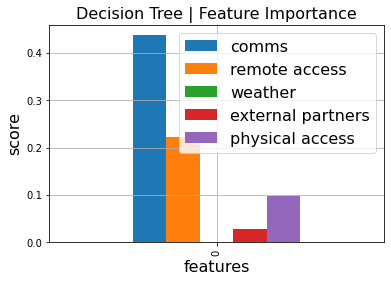

In [6]:
x = plot_importance(my_decision_tree, data_train, labels_train, title='Decision Tree | Feature Importance', features=data_train.columns)

#### Let's drop external partners and weather since they seem to not have importance. I thought about taking off physical access as well, but since it was high in our decision tree above I decided to explore with it included. 

In [18]:
new_data_train = data_train.drop(columns=['weather', 'external partners'])
new_data_test = data_test.drop(columns=['weather', 'external partners'])
new_labels_train = labels_train  # For sake of completeness we'll just copy it over to new variables
new_labels_test = labels_test

In [19]:
new_data_train.head()

,comms,remote access,physical access
50,-0.278772,1.253518,0.197515
2,-0.752438,-1.515338,-1.188724
17,-4.469309,2.173942,0.479370
85,2.860472,1.454695,-3.255675
5,1.223636,0.462238,-1.157077


In [20]:
new_tree = DecisionTreeClassifier(criterion='entropy', random_state=7)
new_tree.fit(X=new_data_train, y=labels_train)

DecisionTreeClassifier(criterion='entropy', random_state=7)

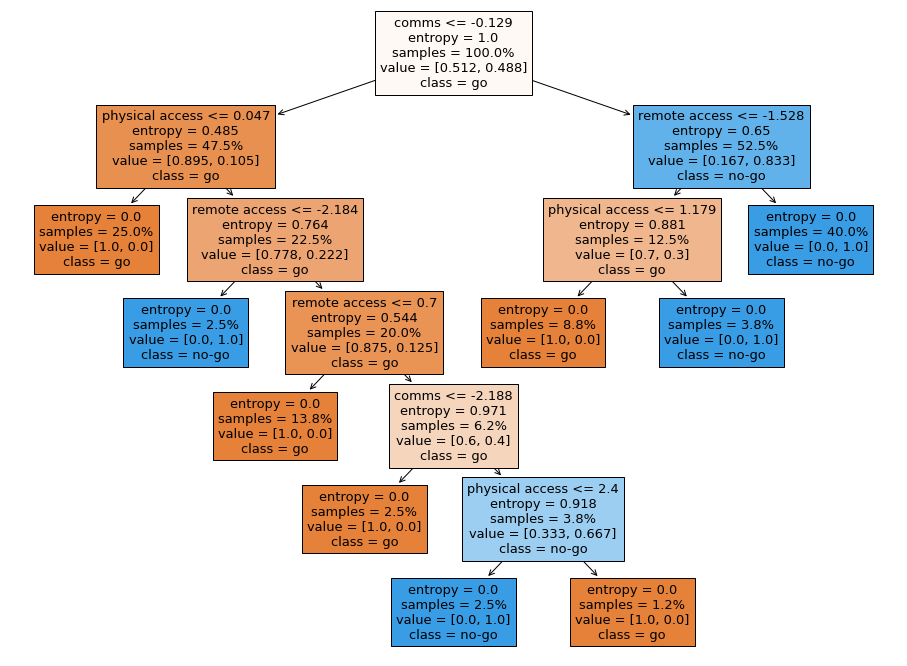

In [21]:
plt.figure(figsize=(16,12))
tree.plot_tree(new_tree, feature_names=new_data_train.columns, class_names=['go', 'no-go'], filled=True, proportion=True)
plt.show()

#### It added more complexity by re-evaluating `comms` again, interesting! Did the accuracy improve by removing "unimportant" features?

In [22]:
mean_accuracy = new_tree.score(X=new_data_test, y=new_labels_test)
print('mean accuracy: {}%'.format(mean_accuracy * 100))

mean accuracy: 80.0%


#### Interesting. So we removed "unimportant" features resulting in a more complex decision tree model and we didn't even gain more accuracy capability. Boooo!

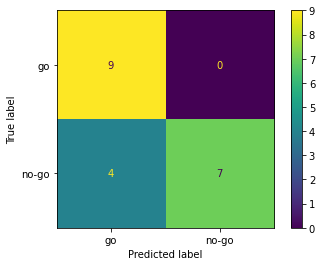

In [23]:
plot_confusion_matrix(new_tree, X=new_data_test, y_true=new_labels_test, display_labels=['go', 'no-go'])

#### It didn't even improve it's accuracy, what the heck? It even got the same examples confused! Well, this makes sense because in our previous decision tree it didn't even consider weather, and although it did consider external partners (once) it seems that removing that didn't affect it's confusion and added to this model's decision complexity. 

# As an exercise, choose different features to drop and graph the decision tree's logic. Does anything happen to its logic?

This function will also present your model's accuracy and confusion matrix

In [13]:
def plot_not_these_features(features=['weather', 'external partners']):
    temp_data_train = data_train.drop(columns=features)
    temp_data_test = data_test.drop(columns=features)
    the_tree = DecisionTreeClassifier(criterion='entropy', random_state=7)
    the_tree.fit(X=temp_data_train, y=labels_train)
    
    # Plot Decision Tree's logic
    plt.figure(figsize=(16,12))
    tree.plot_tree(the_tree, feature_names=temp_data_train.columns, class_names=['go', 'no-go'], filled=True, proportion=True)
    plt.show()
    
    # Print tree's accuracy
    mean_accuracy = the_tree.score(X=temp_data_test, y=labels_test)
    print('\nmean accuracy: {}%\n'.format(mean_accuracy * 100))
    
    # Plot confusion matrix
    plot_confusion_matrix(the_tree, X=temp_data_test, y_true=labels_test, display_labels=['go', 'no-go'])

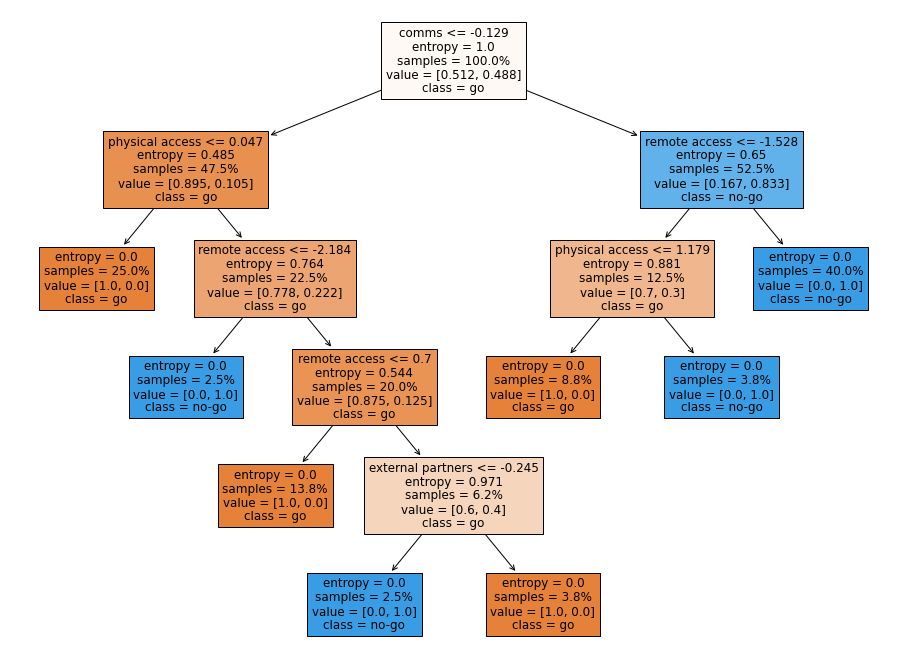


mean accuracy: 80.0%



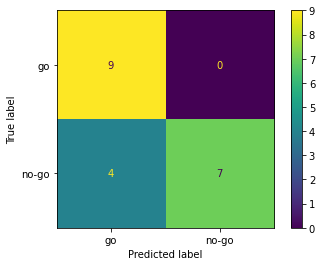

In [14]:
plot_not_these_features(features=['weather'])

## How can we improve our model? Are we just done here? Is there no hope?

What we haven't talked about, and will not in this session, is hyper-parameter tuning. Hyper-parameters are the parts of the machine learning model we can adjust in order to determing which settings of the model produce the most accurate model. In other words, we twist-and-turn these hyper-parameter knobs and tune them resulting in the most optimal model. 

Another model-driven enhancement specific to Decision Trees is something called pruning. This is where we experiment with removing leaves and parent nodes to improve the model's accuracy (or some other performace measure). This also reduces the complexity of the model and sometimes improves the model's general accuracy. 

Other techniques are cross-validation, data normalization and other data transformations, etc. There are numerous ways, but it boils down to your domain knowledge and experimentation with various techniques (chosen by experience, theory, or curiosity). There is no model that rules them all. 

What I'd like to continue with is the idea of gathering more data and its affect on ML models, as well as showcase how data can change over time. Let's go to Decision-Trees-2 first, then Feature-to-Model-2, and finally we'll go to Data-Analysis-2. 